In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import random
import seaborn as sns

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
# Improved El Farol Bar Simulation with Dynamic Behavior and Better Rewards
import random
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from tqdm import tqdm

# Parameters
N_AGENTS = 100
BAR_CAPACITY = 60
TOO_FEW = 20
WEEKS = 100
SEQUENCE_LENGTH = 300 # Keep 1:3 ratio for weeks to sequence length

# Generate dummy attendance history with high initial attendance
def generate_initial_attendance(weeks=SEQUENCE_LENGTH):
    return [random.randint(50, 80) for _ in range(weeks)]

# Build LSTM predictor
def build_lstm_model():
    model = Sequential([
        LSTM(32, input_shape=(SEQUENCE_LENGTH, 1), return_sequences=False),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Q-learning Agent with LSTM and personality traits
class Agent:
    def __init__(self, agent_id, total_agents):
        self.agent_id = agent_id  # Unique ID for the agent
        self.q_table = np.zeros((2,))  # 0: stay home, 1: go
        self.alpha = 0.1
        self.gamma = 0.95

        # Personality traits
        self.risk_tolerance = random.uniform(0.1, 1.0)  # Risk tolerance (affects epsilon)
        self.memory_length = random.randint(5, 20)  # Memory length for recent rewards
        self.social_influence = random.uniform(0.1, 1.0)  # Weight for known agents' rewards

        # Exploration rate (epsilon) influenced by risk tolerance
        self.epsilon = 0.5 * self.risk_tolerance

        self.lstm = build_lstm_model()
        self.past_attendance = generate_initial_attendance()
        self.recent_rewards = []  # Track recent rewards for dynamic epsilon adjustment
        self.known_agents = random.sample(range(total_agents), k=random.randint(1, 10))  # Randomly know 1-10 agents

        # Train LSTM model on initial attendance history
        X = np.array([self.past_attendance[i:i+SEQUENCE_LENGTH] for i in range(len(self.past_attendance) - SEQUENCE_LENGTH)])
        y = np.array(self.past_attendance[SEQUENCE_LENGTH:])
        if len(X) > 0:
            self.lstm.fit(X.reshape(-1, SEQUENCE_LENGTH, 1), y, epochs=50, verbose=0)

    def adjust_epsilon(self):
        if len(self.recent_rewards) > 0:
            avg_reward = np.mean(self.recent_rewards)
            if avg_reward > 1:  # Positive rewards
                self.epsilon = max(0.1, self.epsilon * 0.95)
            elif avg_reward < 0:  # Negative rewards
                self.epsilon = min(1.0, self.epsilon * 1.05)

    def predict_attendance(self):
        sequence = np.array(self.past_attendance[-SEQUENCE_LENGTH:]).reshape(1, SEQUENCE_LENGTH, 1)
        prediction = self.lstm.predict(sequence, verbose=0)[0][0]
        return prediction

    def decide(self, predicted_attendance, known_rewards):
        # Influence decision based on known rewards and social influence
        if len(known_rewards) > 0:
            avg_known_reward = np.mean(known_rewards)
            weighted_reward = avg_known_reward * self.social_influence
            if weighted_reward > 1:  # Positive influence
                self.epsilon = max(0.1, self.epsilon * 0.95)
            elif weighted_reward < 0:  # Negative influence
                self.epsilon = min(1.0, self.epsilon * 1.05)

        # Decide based on epsilon-greedy strategy
        if random.random() < self.epsilon:
            return random.choice([0, 1])
        else:
            return np.argmax(self.q_table)

    def update_q(self, action, reward):
        self.q_table[action] += self.alpha * (reward + self.gamma * np.max(self.q_table) - self.q_table[action])
        self.recent_rewards.append(reward)  # Track the reward
        if len(self.recent_rewards) > self.memory_length:  # Keep rewards within memory length
            self.recent_rewards.pop(0)

    def update_attendance_history(self, value):
        self.past_attendance.append(value)
        if len(self.past_attendance) > SEQUENCE_LENGTH + 1:
            self.past_attendance.pop(0)

# Initialize agents with personality traits
agents = [Agent(agent_id=i, total_agents=N_AGENTS) for i in range(N_AGENTS)]

# Simulation
history = generate_initial_attendance(weeks=SEQUENCE_LENGTH)
raw_attendance = []  # Track original attendance before early leaving
epsilon_tracking = []  # Track average epsilon per week

for week in tqdm(range(WEEKS), desc="Simulating Weeks"):
    decisions = []
    predictions = []

    for agent in agents:
        pred = agent.predict_attendance()
        predictions.append(pred)

        # Gather rewards from known agents
        known_rewards = [agents[known_id].recent_rewards[-1] for known_id in agent.known_agents if agents[known_id].recent_rewards]

        # Make a decision influenced by known agents
        action = agent.decide(pred, known_rewards)
        decisions.append(action)

    attendance = sum(decisions)
    raw_attendance.append(attendance)  # Capture original attendance (before early leaving)

    # Dynamic early leaving if overcrowded
    if attendance > BAR_CAPACITY:
        leavers = int(0.3 * attendance)  # 30% leave early due to discomfort
        attendance -= leavers

    history.append(attendance)
    history = history[-(SEQUENCE_LENGTH + 1):]

    for i, agent in enumerate(agents):
        if decisions[i] == 1 and attendance <= BAR_CAPACITY and attendance > TOO_FEW:
            reward = 2  # Reward for attending when the bar is not overcrowded and not too empty
        elif decisions[i] == 1 and attendance <= TOO_FEW:
            reward = -1  # Punishment for attending when the bar is too empty
        elif decisions[i] == 1:
            reward = -2  # Punishment for attending when the bar is overcrowded
        else:
            reward = 0.5  # Reward for staying home
        agent.update_q(decisions[i], reward)
        agent.update_attendance_history(attendance)
        agent.adjust_epsilon()  # Adjust epsilon dynamically

    # Calculate and record the average epsilon for this week
    avg_epsilon = np.mean([agent.epsilon for agent in agents])
    epsilon_tracking.append(avg_epsilon)

    # Print average epsilon for debugging
    # print(f"Week {week}: Average Epsilon = {avg_epsilon}")

C:\Users\k3n\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Simulating Weeks:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating Weeks: 100%|██████████| 100/100 [12:50<00:00,  7.71s/it]


In [3]:
print("BAR_CAPACITY:", BAR_CAPACITY)
print("N_AGENTS:", N_AGENTS)
print("SEQUENCE_LENGTH:", SEQUENCE_LENGTH)
print("WEEKS:", WEEKS)
print("Current Week:", week)
print("Attendance:", attendance)
print("Decisions:", decisions)
print("Predictions:", predictions)
print("History:", history)
print("Reward:", reward)

BAR_CAPACITY: 60
N_AGENTS: 100
SEQUENCE_LENGTH: 300
WEEKS: 100
Current Week: 99
Attendance: 33
Decisions: [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0]
Predictions: [0.10854497, -0.57241315, -0.20456432, 0.20700862, 0.2156022, 0.85170764, -0.4606974, -0.32602933, 0.8520541, -0.67040986, 0.43265212, -0.3806776, 0.9583234, -0.14638868, -1.3870897, 1.3577642, 0.53686434, -0.12676509, 0.14640658, 1.1930673, 1.2281138, -0.108607374, 0.7562104, -0.5552517, -0.34353364, 0.7554737, -0.8005803, 0.85137314, -0.86238205, -0.9523189, -0.21851726, -0.13430697, 0.57322234, -0.8173508, 0.9491713, 0.3747574, -0.33983654, 0.48536927, 0.94516945, 0.09514671, 0.003335738, -0.80894053, -0.5662426, -0.2330892, -0.70038956, -0.76779974, -0.10313389, -0.1934

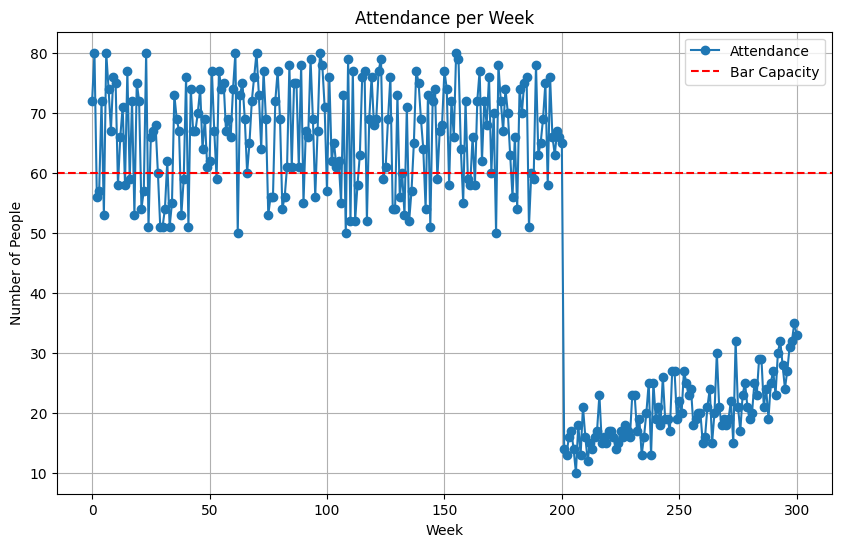

In [4]:
import matplotlib.pyplot as plt

# Plot attendance history
plt.figure(figsize=(10, 6))
plt.plot(range(len(history)), history, marker='o', label='Attendance')
plt.axhline(y=BAR_CAPACITY, color='r', linestyle='--', label='Bar Capacity')
plt.title('Attendance per Week')
plt.xlabel('Week')
plt.ylabel('Number of People')
plt.legend()
plt.grid()
plt.show()

In [5]:
from collections import Counter

# Count the frequency of attendance values
attendance_frequency = Counter(history)

# Display the frequency
print("Attendance Frequency per Week:")
for attendance_value, frequency in sorted(attendance_frequency.items()):
    print(f"Attendance: {attendance_value}, Frequency: {frequency}")

Attendance Frequency per Week:
Attendance: 10, Frequency: 1
Attendance: 12, Frequency: 1
Attendance: 13, Frequency: 4
Attendance: 14, Frequency: 4
Attendance: 15, Frequency: 7
Attendance: 16, Frequency: 9
Attendance: 17, Frequency: 9
Attendance: 18, Frequency: 6
Attendance: 19, Frequency: 10
Attendance: 20, Frequency: 6
Attendance: 21, Frequency: 7
Attendance: 22, Frequency: 2
Attendance: 23, Frequency: 7
Attendance: 24, Frequency: 4
Attendance: 25, Frequency: 6
Attendance: 26, Frequency: 1
Attendance: 27, Frequency: 5
Attendance: 28, Frequency: 1
Attendance: 29, Frequency: 2
Attendance: 30, Frequency: 2
Attendance: 31, Frequency: 1
Attendance: 32, Frequency: 3
Attendance: 33, Frequency: 1
Attendance: 35, Frequency: 1
Attendance: 50, Frequency: 3
Attendance: 51, Frequency: 7
Attendance: 52, Frequency: 4
Attendance: 53, Frequency: 5
Attendance: 54, Frequency: 7
Attendance: 55, Frequency: 4
Attendance: 56, Frequency: 7
Attendance: 57, Frequency: 4
Attendance: 58, Frequency: 7
Attendance:

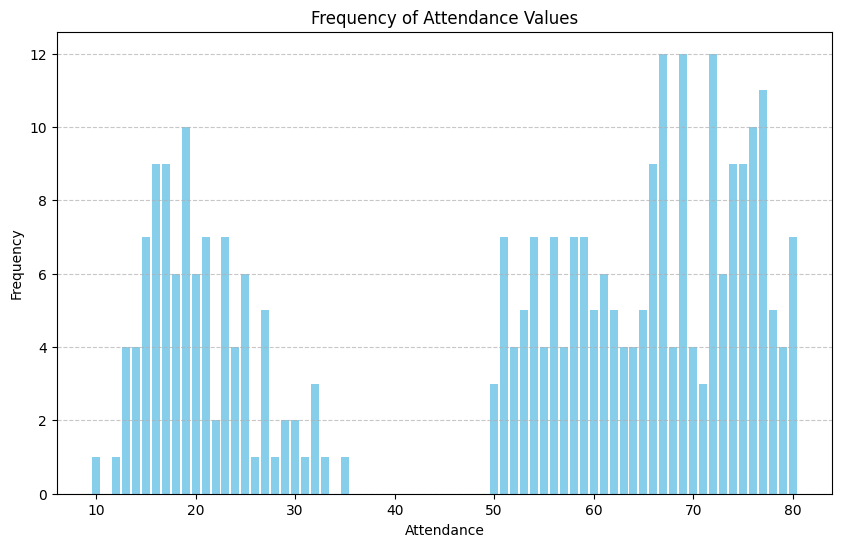

In [6]:
# Visualize the frequency of attendance values
plt.figure(figsize=(10, 6))
plt.bar(attendance_frequency.keys(), attendance_frequency.values(), color='skyblue')
plt.title('Frequency of Attendance Values')
plt.xlabel('Attendance')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


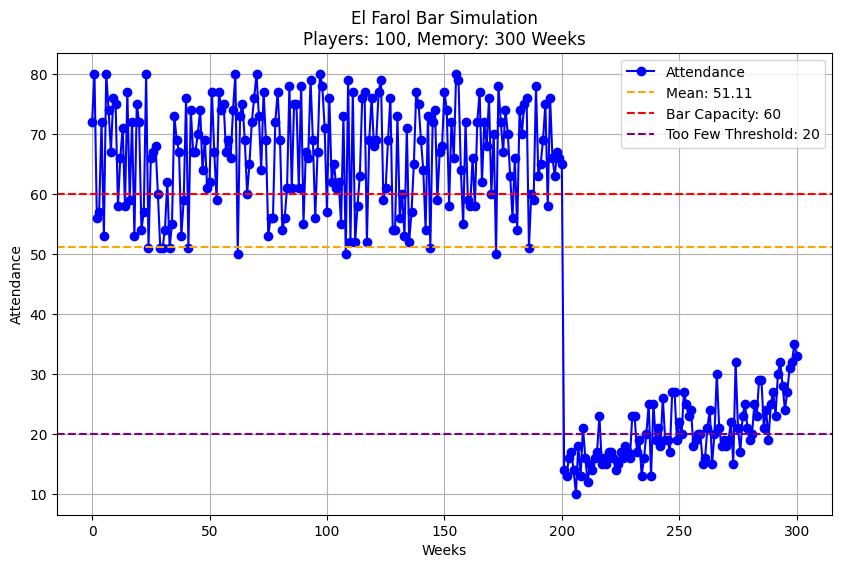

In [7]:
# Calculate the mean attendance
mean_data = np.mean(history)

# Plot the attendance history, mean, bar capacity, and too few threshold
plt.figure(figsize=(10, 6))
plt.plot(history, label='Attendance', marker='o', color='blue')
plt.axhline(y=mean_data, color='orange', linestyle='--', label='Mean: ' + str(round(mean_data, 2)))
plt.axhline(y=BAR_CAPACITY, color='red', linestyle='--', label='Bar Capacity: ' + str(BAR_CAPACITY))
plt.axhline(y=TOO_FEW, color='purple', linestyle='--', label='Too Few Threshold: ' + str(TOO_FEW))
plt.legend()
plt.xlabel("Weeks")
plt.ylabel("Attendance")
plt.grid()
plt.title("El Farol Bar Simulation\nPlayers: " + str(N_AGENTS) + ", Memory: " + str(SEQUENCE_LENGTH) + " Weeks")
plt.show()

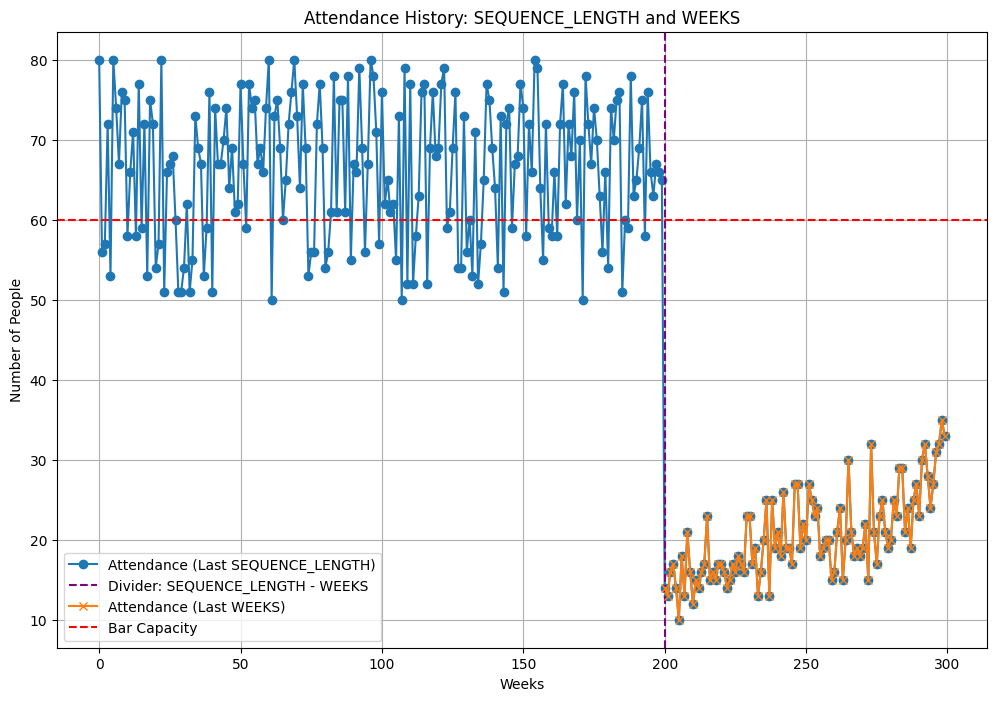

In [8]:
# Plot attendance history for SEQUENCE_LENGTH and WEEKS
plt.figure(figsize=(12, 8))

# Plot data for SEQUENCE_LENGTH
plt.plot(range(SEQUENCE_LENGTH), history[-SEQUENCE_LENGTH:], marker='o', label='Attendance (Last SEQUENCE_LENGTH)')

# Add a divider label
plt.axvline(x=SEQUENCE_LENGTH - WEEKS, color='purple', linestyle='--', label='Divider: SEQUENCE_LENGTH - WEEKS')

# Plot data for WEEKS
plt.plot(range(SEQUENCE_LENGTH - WEEKS, SEQUENCE_LENGTH), history[-WEEKS:], marker='x', label='Attendance (Last WEEKS)')

# Add labels and legend
plt.axhline(y=BAR_CAPACITY, color='r', linestyle='--', label='Bar Capacity')
plt.title('Attendance History: SEQUENCE_LENGTH and WEEKS')
plt.xlabel('Weeks')
plt.ylabel('Number of People')
plt.legend()
plt.grid()
plt.show()

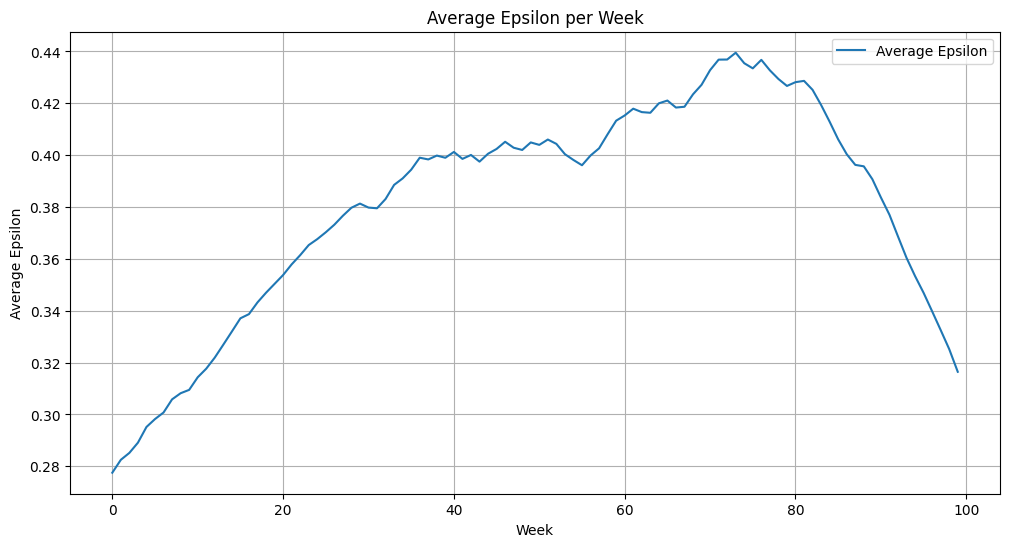

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(range(WEEKS), epsilon_tracking, label='Average Epsilon')
plt.title('Average Epsilon per Week')
plt.xlabel('Week')
plt.ylabel('Average Epsilon')
plt.grid()
plt.legend()
plt.show()

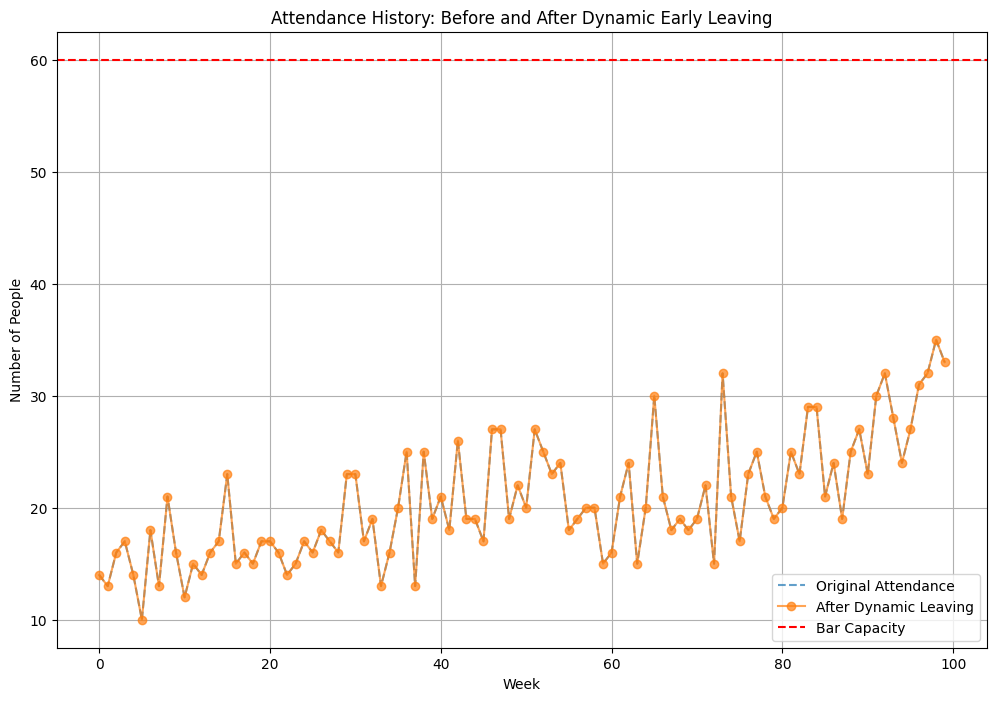

In [10]:
plt.figure(figsize=(12, 8))

# Plot original attendance (before dynamic early leaving)
plt.plot(range(WEEKS), raw_attendance, label='Original Attendance', linestyle='--', alpha=0.7)

# Plot attendance after applying early leaving
plt.plot(range(WEEKS), history[-WEEKS:], label='After Dynamic Leaving', marker='o', alpha=0.7)

# Bar capacity line
plt.axhline(y=BAR_CAPACITY, color='r', linestyle='--', label='Bar Capacity')

plt.title('Attendance History: Before and After Dynamic Early Leaving')
plt.xlabel('Week')
plt.ylabel('Number of People')
plt.legend()
plt.grid(True)
plt.show()

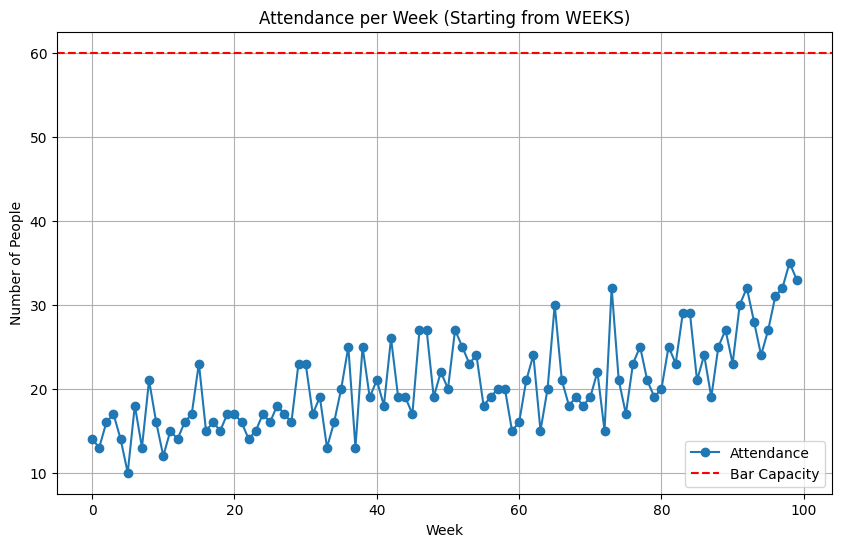

In [11]:
# Plot attendance history starting from WEEKS
plt.figure(figsize=(10, 6))
plt.plot(range(WEEKS), history[-WEEKS:], marker='o', label='Attendance')
plt.axhline(y=BAR_CAPACITY, color='r', linestyle='--', label='Bar Capacity')
plt.title('Attendance per Week (Starting from WEEKS)')
plt.xlabel('Week')
plt.ylabel('Number of People')
plt.legend()
plt.grid()
plt.show()

In [12]:
for idx, agent in enumerate(agents):
    print(f"Agent {idx}:")
    print(f"  Q-Table: {agent.q_table}")
    print(f"  Epsilon: {agent.epsilon}")
    print(f"  Past Attendance: {agent.past_attendance}")
    print()

Agent 0:
  Q-Table: [3.66275718 0.85784678]
  Epsilon: 0.12784534991550942
  Past Attendance: [55, 66, 64, 79, 62, 72, 55, 67, 70, 60, 62, 63, 54, 51, 53, 52, 67, 54, 67, 68, 63, 72, 74, 80, 67, 74, 57, 57, 63, 73, 73, 65, 66, 65, 74, 62, 55, 77, 61, 79, 66, 59, 56, 54, 78, 59, 57, 75, 62, 57, 50, 72, 69, 74, 68, 69, 70, 76, 51, 56, 72, 65, 80, 59, 54, 50, 80, 63, 64, 63, 51, 67, 80, 53, 67, 68, 71, 72, 71, 79, 78, 50, 53, 64, 58, 67, 76, 63, 51, 58, 77, 73, 57, 66, 72, 51, 74, 79, 67, 51, 55, 72, 54, 78, 59, 67, 52, 64, 52, 70, 73, 62, 54, 63, 55, 52, 56, 57, 57, 68, 61, 77, 74, 57, 66, 57, 74, 80, 51, 57, 57, 74, 71, 75, 62, 60, 68, 60, 58, 62, 51, 74, 67, 62, 78, 50, 70, 71, 64, 51, 60, 74, 53, 79, 66, 54, 72, 66, 52, 58, 68, 74, 78, 69, 74, 72, 69, 61, 57, 56, 73, 79, 74, 63, 73, 69, 55, 68, 75, 68, 80, 54, 76, 55, 64, 71, 54, 72, 77, 65, 54, 64, 57, 73, 55, 73, 57, 59, 61, 56, 65, 14, 13, 16, 17, 14, 10, 18, 13, 21, 16, 12, 15, 14, 16, 17, 23, 15, 16, 15, 17, 17, 16, 14, 15, 17, 1

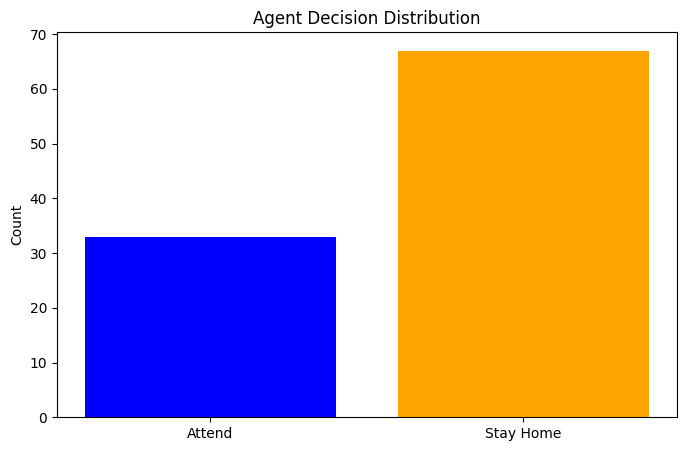

In [13]:
decisions_count = [sum(decisions), len(decisions) - sum(decisions)]
plt.figure(figsize=(8, 5))
plt.bar(['Attend', 'Stay Home'], decisions_count, color=['blue', 'orange'])
plt.title('Agent Decision Distribution')
plt.ylabel('Count')
plt.show()

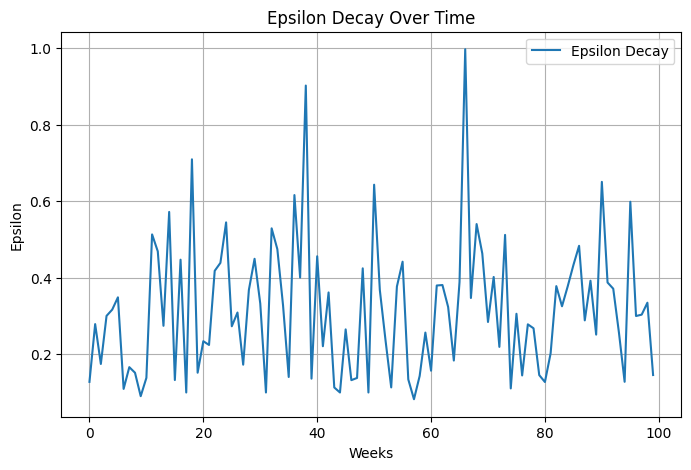

In [14]:
epsilon_values = [agent.epsilon for agent in agents]
plt.figure(figsize=(8, 5))
plt.plot(range(len(epsilon_values)), epsilon_values, label='Epsilon Decay')
plt.title('Epsilon Decay Over Time')
plt.xlabel('Weeks')
plt.ylabel('Epsilon')
plt.grid()
plt.legend()
plt.show()

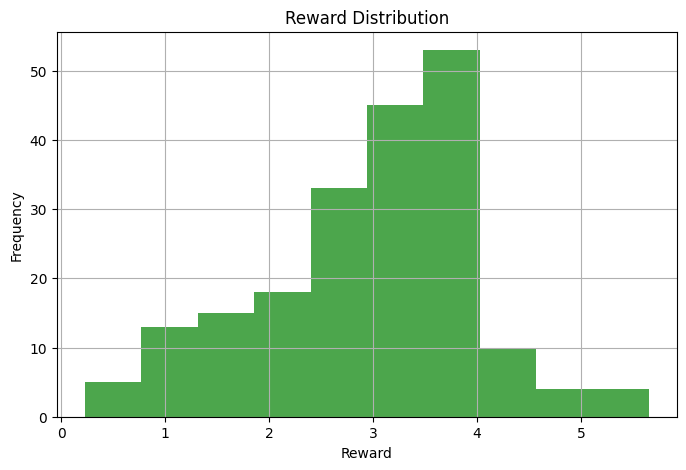

In [15]:
rewards = [reward for agent in agents for reward in agent.q_table]
plt.figure(figsize=(8, 5))
plt.hist(rewards, bins=10, color='green', alpha=0.7)
plt.title('Reward Distribution')
plt.xlabel('Reward')
plt.ylabel('Frequency')
plt.grid()
plt.show()

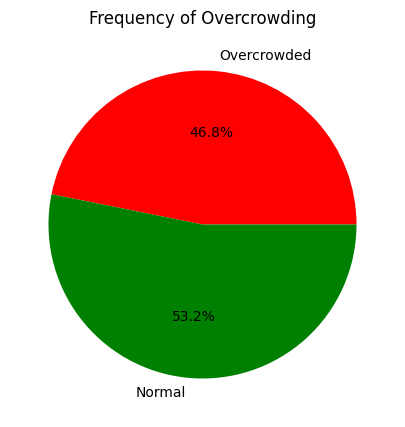

In [16]:
overcrowded_weeks = sum(1 for a in history if a > BAR_CAPACITY)
normal_weeks = len(history) - overcrowded_weeks
plt.figure(figsize=(8, 5))
plt.pie([overcrowded_weeks, normal_weeks], labels=['Overcrowded', 'Normal'], autopct='%1.1f%%', colors=['red', 'green'])
plt.title('Frequency of Overcrowding')
plt.show()

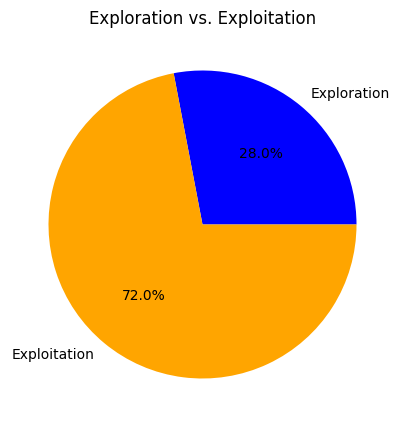

In [17]:
exploration_count = sum(1 for agent in agents if random.random() < agent.epsilon)
exploitation_count = len(agents) - exploration_count
plt.figure(figsize=(8, 5))
plt.pie([exploration_count, exploitation_count], labels=['Exploration', 'Exploitation'], autopct='%1.1f%%', colors=['blue', 'orange'])
plt.title('Exploration vs. Exploitation')
plt.show()